# Best Time to Fly To Minimize Delayed Arrivals
## by Leqi Lu

## Investigation Overview

In this investigation, I want to look at the factors that might cause delays in flights and try to figure out what the best time to fly is. The main focus is on scheduled departure time, time of day, day of week and flight carriers.

## Dataset Overview

This document explores a dataset containing flight arrival and departure details for all commercial flights within the USA, from October 1987 to April 2008. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# retrieve names of all the csv files 
import os
import re

pattern = '\d+.csv'
csv_files = [x for x in os.listdir() if re.match(pattern, x)]
print(csv_files)

['1987.csv', '1988.csv', '1989.csv', '1990.csv', '1991.csv', '1992.csv', '1993.csv', '1994.csv', '1995.csv', '1996.csv', '1997.csv', '1998.csv', '1999.csv', '2000.csv', '2001.csv', '2002.csv', '2003.csv', '2004.csv', '2005.csv', '2006.csv', '2007.csv', '2008.csv']


In [3]:
# function to sample 10000 entries from each year's data  
# and load all the sampled data into flights_sample

def load_data(filenames, flights_sample):
    for filename in filenames:
        print(filename)
        df = pd.read_csv(filename, low_memory=False)
        df_sample = df.sample(10000, random_state=67)
        flights_sample = pd.concat([flights_sample, df_sample], axis=0)
        flights_sample.reset_index(drop=True, inplace=True)
        del df
    return flights_sample

In [4]:
flights_sample_original = pd.DataFrame()
flights_sample_original = load_data(csv_files, flights_sample_original)

1987.csv
1988.csv
1989.csv
1990.csv
1991.csv
1992.csv
1993.csv
1994.csv
1995.csv
1996.csv
1997.csv
1998.csv
1999.csv
2000.csv
2001.csv
2002.csv
2003.csv
2004.csv
2005.csv
2006.csv
2007.csv
2008.csv


In [5]:
# dropping less relevant columns
flights_sample_original = flights_sample_original.drop(columns=['FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime',
                             'Origin', 'Dest', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 
                             'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'])

### Quality

- ~Erroneous datatypes (DepTime, CRSDepTime, ArrTime, CRSArrTime, ArrDelay, DepDelay)~
- ~Missing information on Deptime, ArrTime, ArrDelay, DepDelay, Distance)~

### Tidiness
- ~DayofMonth does not follow naming convention~

In [6]:
flights_sample = flights_sample_original.copy()

#### DayofMonth does not follow naming convention

##### Define
Change DayofMonth to DayOfMonth

##### Code

In [7]:
flights_sample = flights_sample.rename(columns={'DayofMonth': 'DayOfMonth'})

In [8]:
# check null DepTime records
dep_null = flights_sample['DepTime'].isnull()
flights_sample.loc[dep_null, :].describe()

,Year,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ArrDelay,DepDelay,Distance
count,4074.000000,4074.000000,4074.000000,4074.000000,0.0,4074.000000,0.0,4074.000000,0.0,0.0,4068.000000
mean,1998.767059,6.218949,15.335052,3.766814,NaN,1336.668630,NaN,1489.431762,NaN,NaN,604.562930
std,5.851504,3.774997,8.569321,1.923179,NaN,473.834831,NaN,494.384986,NaN,NaN,479.536708
min,1987.000000,1.000000,1.000000,1.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,24.000000
25%,1995.000000,3.000000,8.000000,2.000000,NaN,930.000000,NaN,1116.250000,NaN,NaN,265.500000
50%,1999.000000,6.000000,15.000000,4.000000,NaN,1340.000000,NaN,1528.500000,NaN,NaN,448.000000
75%,2003.000000,9.000000,23.000000,5.000000,NaN,1725.000000,NaN,1908.000000,NaN,NaN,799.000000
max,2008.000000,12.000000,31.000000,7.000000,NaN,2359.000000,NaN,2359.000000,NaN,NaN,3801.000000


In [9]:
# dep_null records are all missing DepTime, ArrTime, ArrDelay and DepDelay, we could remove them safely
flights_sample.drop(flights_sample.index[dep_null], inplace=True)

In [10]:
# check null arrTime records
arr_null = flights_sample['ArrTime'].isnull()
flights_sample.loc[arr_null, :].describe()

,Year,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ArrDelay,DepDelay,Distance
count,523.000000,523.000000,523.000000,523.000000,523.000000,523.00000,0.0,523.000000,0.0,523.000000,522.000000
mean,1996.606119,6.743786,16.428298,3.963671,1379.527725,1349.31740,NaN,1549.944551,NaN,25.502868,894.764368
std,6.593399,3.583077,8.534364,1.961463,511.588152,494.67929,NaN,515.850786,NaN,74.155769,644.095861
min,1987.000000,1.000000,1.000000,1.000000,19.000000,0.00000,NaN,0.000000,NaN,-855.000000,21.000000
25%,1990.000000,3.500000,9.500000,2.000000,914.000000,900.00000,NaN,1136.000000,NaN,-1.000000,404.500000
50%,1996.000000,7.000000,16.000000,4.000000,1407.000000,1355.00000,NaN,1630.000000,NaN,2.000000,743.500000
75%,2002.000000,10.000000,23.000000,6.000000,1816.000000,1737.00000,NaN,1949.500000,NaN,25.000000,1165.000000
max,2008.000000,12.000000,31.000000,7.000000,2333.000000,2318.00000,NaN,2400.000000,NaN,735.000000,4243.000000


In [11]:
# remove null arrTime records
flights_sample.drop(flights_sample.index[arr_null], inplace=True)

In [12]:
# check null ArrDelay records
arr_delay_null = flights_sample['ArrDelay'].isnull()
flights_sample.loc[arr_delay_null, :]

,Year,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ArrDelay,DepDelay,Distance
210470,2008,10,25,6,1533.0,1540,2312.0,1725,MQ,NaN,-7.0,431.0
213386,2008,12,24,3,941.0,855,1126.0,945,WN,NaN,46.0,181.0
214203,2008,10,26,7,1717.0,1720,908.0,558,NW,NaN,-3.0,3972.0
214563,2008,12,27,6,720.0,650,1240.0,900,MQ,NaN,30.0,1021.0
216466,2008,11,29,6,556.0,600,1101.0,950,UA,NaN,-4.0,2704.0


In [13]:
# manually fill the null entries for ArrDelay
flights_sample.at[210470, 'ArrDelay'] = 547
flights_sample.at[213386, 'ArrDelay'] = 141
flights_sample.at[214203, 'ArrDelay'] = 310
flights_sample.at[214563, 'ArrDelay'] = 340
flights_sample.at[216466, 'ArrDelay'] = 111

In [14]:
flights_sample.loc[arr_delay_null, :]

,Year,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ArrDelay,DepDelay,Distance
210470,2008,10,25,6,1533.0,1540,2312.0,1725,MQ,547.0,-7.0,431.0
213386,2008,12,24,3,941.0,855,1126.0,945,WN,141.0,46.0,181.0
214203,2008,10,26,7,1717.0,1720,908.0,558,NW,310.0,-3.0,3972.0
214563,2008,12,27,6,720.0,650,1240.0,900,MQ,340.0,30.0,1021.0
216466,2008,11,29,6,556.0,600,1101.0,950,UA,111.0,-4.0,2704.0


In [15]:
# check null distance entries
dist_null = flights_sample['Distance'].isnull()
flights_sample.loc[dist_null, :]

,Year,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ArrDelay,DepDelay,Distance
145,1987,12,15,2,1315.0,1255,1554.0,1535,AS,19.0,20.0,NaN
1856,1987,11,20,5,914.0,915,1003.0,945,AS,18.0,-1.0,NaN
2119,1987,11,3,2,700.0,700,749.0,755,AS,-6.0,0.0,NaN
3618,1987,11,3,2,825.0,830,1100.0,1111,AS,-11.0,-5.0,NaN
4913,1987,11,22,7,1547.0,1550,1637.0,1635,AS,2.0,-3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
85875,1995,10,26,4,616.0,615,726.0,719,DL,7.0,1.0,NaN
86902,1995,11,7,2,942.0,942,1049.0,1050,DL,-1.0,0.0,NaN
87278,1995,10,9,1,1040.0,1040,1145.0,1140,WN,5.0,0.0,NaN
89735,1995,11,15,3,1735.0,1735,1915.0,1940,WN,-25.0,0.0,NaN


In [16]:
# there are only 409 entries and we cannot meaningfully fill them with means or medians, 
# so we are removing them
flights_sample.drop(flights_sample.index[dist_null], inplace=True)

##### Test

In [17]:
flights_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214994 entries, 0 to 219999
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           214994 non-null  int64  
 1   Month          214994 non-null  int64  
 2   DayOfMonth     214994 non-null  int64  
 3   DayOfWeek      214994 non-null  int64  
 4   DepTime        214994 non-null  float64
 5   CRSDepTime     214994 non-null  int64  
 6   ArrTime        214994 non-null  float64
 7   CRSArrTime     214994 non-null  int64  
 8   UniqueCarrier  214994 non-null  object 
 9   ArrDelay       214994 non-null  float64
 10  DepDelay       214994 non-null  float64
 11  Distance       214994 non-null  float64
dtypes: float64(5), int64(6), object(1)
memory usage: 21.3+ MB


#### Erroneous datatypes (DepTime, CRSDepTime, ArrTime, CRSArrTime, ArrDelay, DepDelay)
##### Define
Change DepTime, CRSDepTime, ArrTime, CRSArrTime to string, ArrDelay and DepDelay to int.
##### Code

In [18]:
def format_change(columns):
    for c in columns:
        flights_sample[c] = flights_sample[c].astype(int)
        #flights_sample[c] = flights_sample[c].str.replace('\.0', '', regex=True)
        #flights_sample[c] = flights_sample[c].str.zfill(4)

        #flights_sample[c] = flights_sample[c].apply(lambda x: "{}:{}".format(x[:2],x[2:]))

In [19]:
columns = ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'ArrDelay', 'DepDelay']

format_change(columns)

##### Test

In [20]:
flights_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214994 entries, 0 to 219999
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           214994 non-null  int64  
 1   Month          214994 non-null  int64  
 2   DayOfMonth     214994 non-null  int64  
 3   DayOfWeek      214994 non-null  int64  
 4   DepTime        214994 non-null  int32  
 5   CRSDepTime     214994 non-null  int32  
 6   ArrTime        214994 non-null  int32  
 7   CRSArrTime     214994 non-null  int32  
 8   UniqueCarrier  214994 non-null  object 
 9   ArrDelay       214994 non-null  int32  
 10  DepDelay       214994 non-null  int32  
 11  Distance       214994 non-null  float64
dtypes: float64(1), int32(6), int64(4), object(1)
memory usage: 16.4+ MB


In [21]:
flights_sample.head(10)

,Year,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ArrDelay,DepDelay,Distance
0,1987,12,2,3,1945,1945,2050,2045,NW,5,0,256.0
1,1987,11,23,1,1029,1030,1500,1527,CO,-27,-1,1123.0
2,1987,12,7,1,702,704,934,930,UA,4,-2,495.0
3,1987,10,8,4,629,630,945,948,UA,-3,-1,957.0
4,1987,10,26,1,715,715,747,750,HP,-3,0,110.0
5,1987,11,11,3,730,719,845,828,AA,17,11,328.0
6,1987,11,3,2,1800,1800,1934,1918,AA,16,0,337.0
7,1987,11,4,3,1234,1234,1329,1338,EA,-9,0,270.0
8,1987,10,16,5,1626,1628,1653,1654,UA,-1,-2,74.0
9,1987,10,5,1,2137,2135,2221,2220,US,1,2,164.0


In [22]:
flights_sample.to_csv('flights_sample.csv', index=False)

In [23]:
flights_sample = pd.read_csv('flights_sample.csv')
flights_sample.head()

,Year,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ArrDelay,DepDelay,Distance
0,1987,12,2,3,1945,1945,2050,2045,NW,5,0,256.0
1,1987,11,23,1,1029,1030,1500,1527,CO,-27,-1,1123.0
2,1987,12,7,1,702,704,934,930,UA,4,-2,495.0
3,1987,10,8,4,629,630,945,948,UA,-3,-1,957.0
4,1987,10,26,1,715,715,747,750,HP,-3,0,110.0


In [24]:
flights_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214994 entries, 0 to 214993
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           214994 non-null  int64  
 1   Month          214994 non-null  int64  
 2   DayOfMonth     214994 non-null  int64  
 3   DayOfWeek      214994 non-null  int64  
 4   DepTime        214994 non-null  int64  
 5   CRSDepTime     214994 non-null  int64  
 6   ArrTime        214994 non-null  int64  
 7   CRSArrTime     214994 non-null  int64  
 8   UniqueCarrier  214994 non-null  object 
 9   ArrDelay       214994 non-null  int64  
 10  DepDelay       214994 non-null  int64  
 11  Distance       214994 non-null  float64
dtypes: float64(1), int64(10), object(1)
memory usage: 19.7+ MB


In [25]:
# decide if a trip is short/medium/long
conditions = [
    (flights_sample['Distance'] <700),
    (flights_sample['Distance'] >= 700) & (flights_sample['Distance'] < 3000),
    (flights_sample['Distance'] >= 3000)
]

hauls = ['Short', 'Medium', 'Long']

flights_sample['Haul'] = np.select(conditions, hauls)

In [26]:
# make a column to indicate if arrival is on-time 
flights_sample['ArrOnTime'] = flights_sample['ArrDelay'] <= 0

### Distributuion of Delayed Arrival Flights vs On-Time Arrival Flights

There are slightly more on-time arrival flights than delayed ones - 51.4% of all the flights taken between 1987 and 2008 were on time.

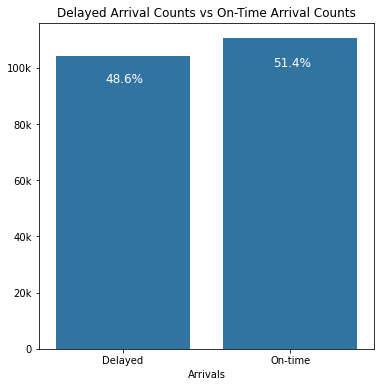

In [27]:
base_color = sb.color_palette()[0]
plt.figure(figsize=[6, 6])

ax = sb.countplot(data=flights_sample, x='ArrOnTime', color=base_color)
plt.xticks([False, True], ['Delayed', 'On-time'])
plt.xlabel('Arrivals')
plt.ylabel('')
plt.yticks([0, 2e4, 4e4, 6e4, 8e4, 1e5], ['0', '20k', '40k', '60k', '80k', '100k'])

plt.title('Delayed Arrival Counts vs On-Time Arrival Counts')

total = flights_sample.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2.7
    y = p.get_y() + p.get_height()/1.1
    ax.annotate(percentage, (x, y), size=12, color='white')

plt.show();

In [28]:
# convert numbers 1-24 into strings
def make_hour_string():
    hours = []
    for i in np.arange(24):
        if i < 10:
            hours.append('0' + str(i) + ":00")
        else:
            hours.append(str(i) + ":00")
    return hours

### Distribution of Flights Over a Day
There is only a few flights between 1 AM and 5 AM, and most of the flights happen between 6 AM and 10 PM, with one peak at around 8 AM, one peak at around 1 PM, and another peak at around 5 PM.

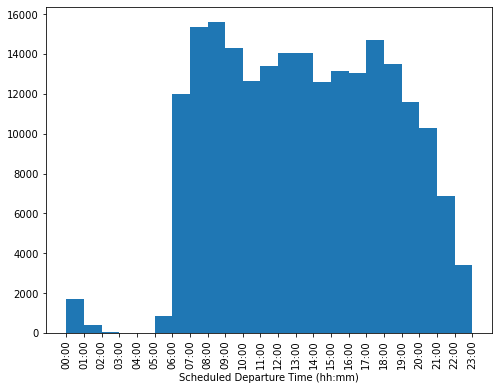

In [29]:
# distribution of scheduled departure time for flights
bins = np.arange(0, 2400, 100)
hours = make_hour_string()

plt.figure(figsize=[8, 6])
plt.hist(data=flights_sample, x='CRSDepTime', bins=bins, color=base_color)
plt.xticks(bins, hours)
plt.xlabel('Scheduled Departure Time (hh:mm)')
plt.ylabel('')
plt.xticks(rotation=90);

### Distribution of Flights among Different Flight Carriers

The most popular airline is DL (Delta Air Lines), the second most popular airline is WN (Southwest). Other popular airlines include AA (American Airlines), US (US Airways), UA (United Airlines), NW (Northwest Airways) and CO (Continental Airlines).

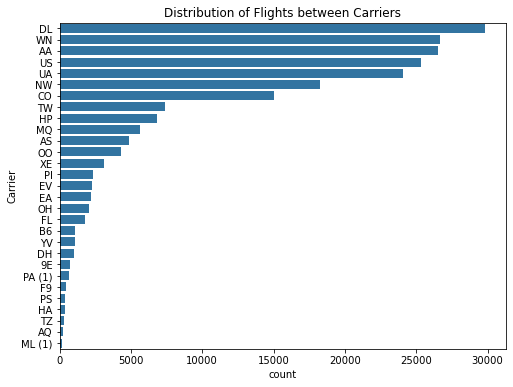

In [30]:
plt.figure(figsize=[8, 6])
sb.countplot(data=flights_sample, y='UniqueCarrier', color=base_color, 
             order=flights_sample['UniqueCarrier'].value_counts().index)
plt.ylabel('Carrier')
plt.title('Distribution of Flights between Carriers');

### Scheduled Departure Time vs Arrival
The violin plot reveals much more than the earlier box plot. It suggests that about 25% of the on-time arrival flights happen in the morning before 9 AM scheduled departure, and 50% before 12:30 PM schedueld departure, while 25% of delayed arrival flights happen before 10 AM and 50% before 2 PM.

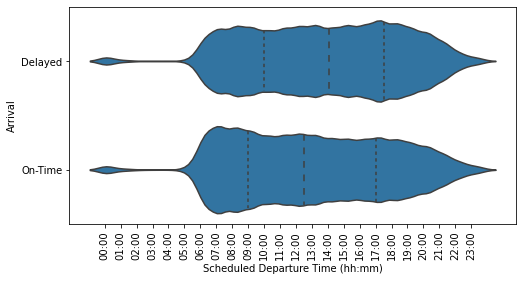

In [31]:
bins = np.arange(0, 2400, 100)
hours = make_hour_string()

plt.figure(figsize=[8, 4])
sb.violinplot(data=flights_sample, y='ArrOnTime', x='CRSDepTime', orient='h', color=base_color, inner='quartile')
plt.xticks(bins, hours)
plt.xlabel('Scheduled Departure Time (hh:mm)')
plt.yticks([False, True], ['Delayed', 'On-Time'])
plt.ylabel('Arrival')
plt.xticks(rotation=90);

In [32]:
def show_percentage(plot, feature, num_of_cat, hue_cat, ax, size):
    height = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    
    for i in range(num_of_cat):
        total = feature.value_counts().sort_index(ascending=True).values[i]
        for j in range(hue_cat):
            percentage = '{:.1f}%'.format(100 * height[(j * num_of_cat + i)] / total)
            x = patch[(j * num_of_cat + i)].get_x() + patch[(j * num_of_cat + i)].get_width() / 2 - 0.17
            y = patch[(j * num_of_cat + i)].get_y() + patch[(j * num_of_cat + i)].get_height()/2
            ax.annotate(percentage, (x, y), size=size)

### Arrival vs Day of Week/Month/Day of Month/Year

Thursday and Friday are having the least on-time arrival flights while having about the similar amount of total flights as the other weekdays. Weekends have less flights in general, but both of the days are having the highest on-time arrival rates. Between all the months, September has the highest rate for on-time arrivals (58.6%), December has the lowest on-time arrivals rate (44.2%) while being one of the most popular months to travel. Most of the months have more than 50% on-time arrival rate except for Jun (49.7%) and December (44.2%). For individual days of the month, we can see that only the 15th, 16th, 19th, 21st, 22nd and 23rd are having more flight delays than on-times. Overall, flights seem to be more on-time than delayed at the beginning of the month as well as at the end of the month. Between 1987 and 2008, the on-time arrival rate of flights has increased drastically, from 40% on-time arrival rate in 1987 to about 58% on-time arrival rate in 2008. We should be able to expect the on-time arrival rate to only get higher and higher from now on.

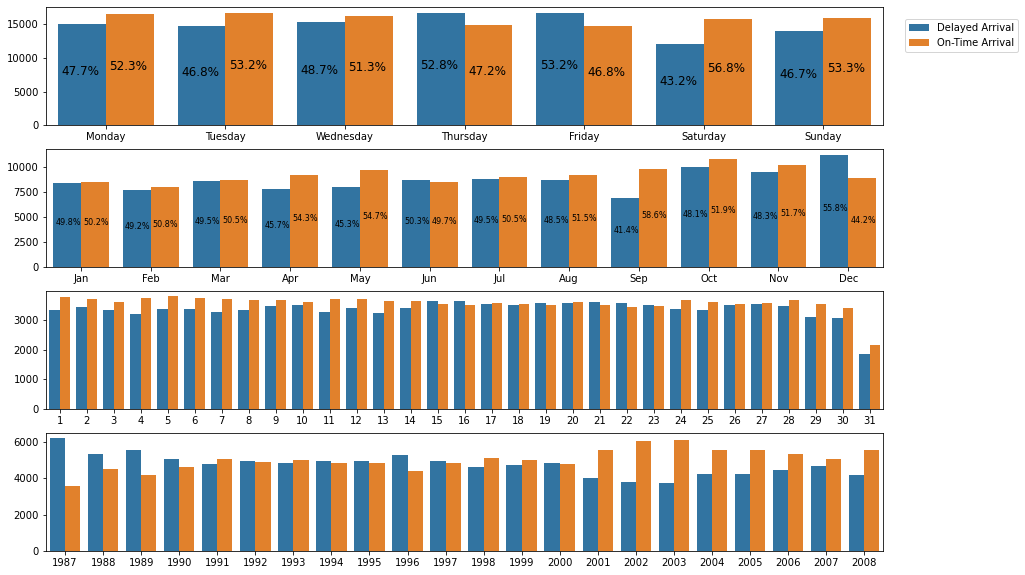

In [33]:
fig, ax = plt.subplots(nrows = 4, figsize = [15,10])

g1 = sb.countplot(data=flights_sample, x='DayOfWeek', hue = 'ArrOnTime', ax=ax[0])
ax[0].set_xticks(np.arange(0, 7, 1))
ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].get_legend().remove()
show_percentage(g1, flights_sample['DayOfWeek'], 7, 2, ax[0], 12)

g2 = sb.countplot(data=flights_sample, x='Month', hue = 'ArrOnTime', ax=ax[1])
ax[1].set_xticks(np.arange(0,12,1))
ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].get_legend().remove()
show_percentage(g2, flights_sample['Month'], 12, 2, ax[1], 8)

sb.countplot(data=flights_sample, x='DayOfMonth', hue = 'ArrOnTime', ax=ax[2])
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].get_legend().remove()

sb.countplot(data=flights_sample, x='Year', hue = 'ArrOnTime', ax=ax[3])
ax[3].set_xlabel('')
ax[3].set_ylabel('')
ax[3].get_legend().remove()

fig.legend(bbox_to_anchor=(1.03, 0.87), labels = ['Delayed Arrival', 'On-Time Arrival']);

### Delayed vs On-Time Arrivals for Different Carriers

For the main airline companies in the United States, DL (Delta Air Lines) operates the most flights in the countries, but its on-time arrival rate does not seem as impressive as the amount of flights its operates. WN (Southwest Airlines) operates the second most flights, while having the most on-time arrival flights between 1987 and 2008. 

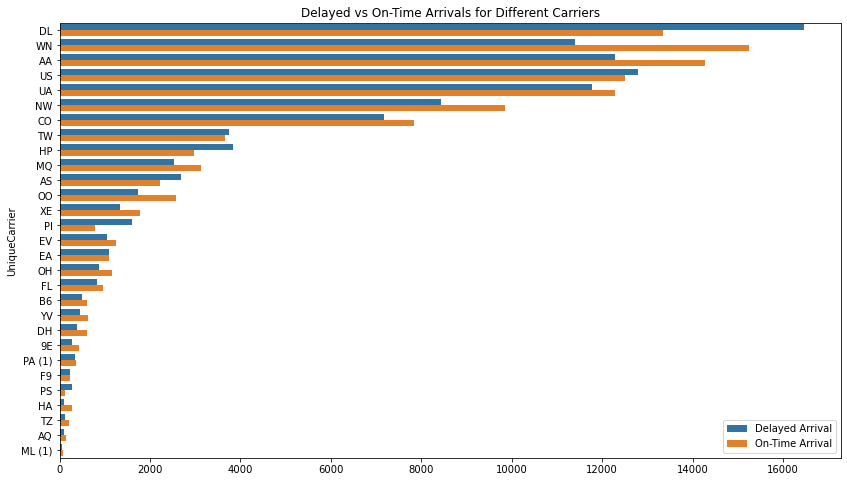

In [34]:
plt.figure(figsize=[14, 8])
ax = sb.countplot(data=flights_sample, y='UniqueCarrier', hue = 'ArrOnTime', 
             order=flights_sample['UniqueCarrier'].value_counts().index)
plt.xlabel('')
plt.title('Delayed vs On-Time Arrivals for Different Carriers')
ax.legend(labels = ['Delayed Arrival', 'On-Time Arrival']);

### Delayed vs On-Time Arrivals based on Day of Week and Scheduled Departure Time

On-time arrival flights usually departs earlier, no matter what day of the week we are flying. Interestingly, for Friday, the first quartile lies around 8:30 AM departures, and second quartile lies around 12:30 PM, much earlier than all the other days of the week.

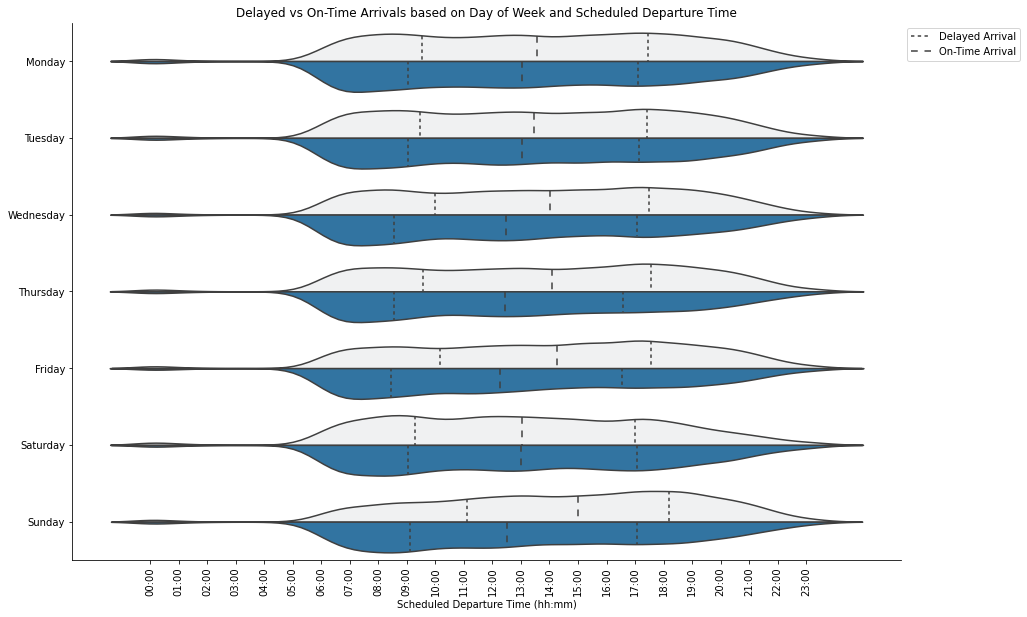

In [35]:
sb.catplot(data=flights_sample, y='DayOfWeek', x='CRSDepTime', hue='ArrOnTime', 
           orient='h', split=True, color=base_color, kind='violin', 
           inner='quartile', legend=False, height=8, aspect=1.5)

plt.xticks(np.arange(0, 2400, 100), hours)
plt.xlabel('Scheduled Departure Time (hh:mm)')
plt.xticks(rotation=90)
plt.ylabel('')
plt.yticks(np.arange(0, 7, 1), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.title('Delayed vs On-Time Arrivals based on Day of Week and Scheduled Departure Time')
plt.legend(bbox_to_anchor=(1.15, 1), labels = ['Delayed Arrival', 'On-Time Arrival']);

In [36]:
# choose carriers with more than 10,000 entries for the 22 years
carriers = ['DL', 'WN', 'AA', 'US', 'UA', 'NW', 'CO']
flights_sample_sub = flights_sample.loc[flights_sample['UniqueCarrier'].isin(carriers)]

df = flights_sample_sub.groupby(['DayOfWeek','UniqueCarrier']).agg({'ArrOnTime': 'sum'})/flights_sample_sub.groupby(['DayOfWeek','UniqueCarrier']).count()
df['ArrOnTime']

DayOfWeek  UniqueCarrier
1          AA               0.535083
           CO               0.529439
           DL               0.453416
           NW               0.551282
           UA               0.508877
           US               0.512767
           WN               0.604841
2          AA               0.557470
           CO               0.515858
           DL               0.462424
           NW               0.519144
           UA               0.522701
           US               0.501454
           WN               0.629630
3          AA               0.539916
           CO               0.511233
           DL               0.435425
           NW               0.515592
           UA               0.495235
           US               0.486126
           WN               0.605010
4          AA               0.489780
           CO               0.478723
           DL               0.396696
           NW               0.503562
           UA               0.463950
           US

### On-Time Arrival Rates for Different Carriers between Each Day of the Week

DL (Delta Air Lines) has the lowest on-time rate for all the days of the week. WN (Southwest Airlines) does an excellent job on Mondays, Tuesdays and Wednesdays - it has 5% more than the second place carrier on on-time arrial rate. It also performs well on Saturday. On Fridays and Sundays, NW (Northwest Airways) has the highest on-time arrival rate. 

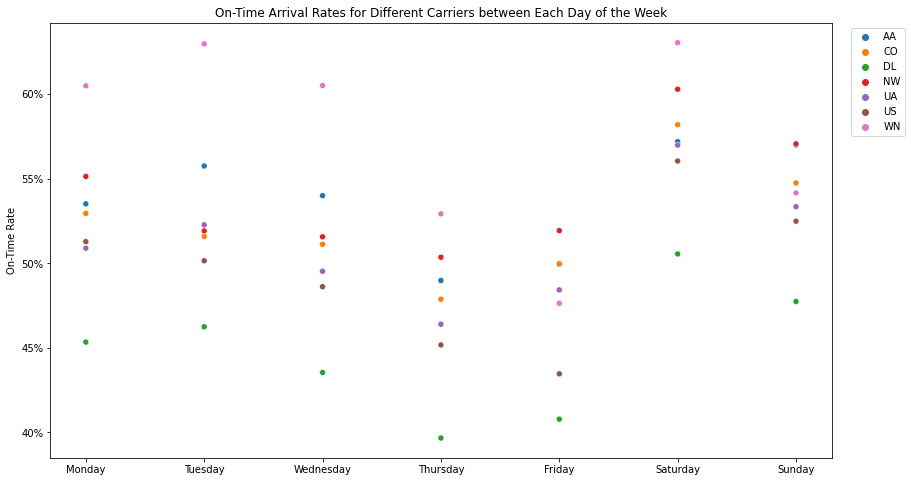

In [37]:
plt.figure(figsize=[14, 8])
sb.scatterplot(data=df, x='DayOfWeek', y='ArrOnTime', hue='UniqueCarrier')

plt.yticks([0.4,0.45,0.5,0.55, 0.6] , ['40%', '45%', '50%', '55%', '60%'])

plt.xlabel('')
plt.ylabel('On-Time Rate')

plt.xticks(np.arange(1, 8, 1), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
plt.title('On-Time Arrival Rates for Different Carriers between Each Day of the Week')
plt.legend(bbox_to_anchor=(1.1, 1));

In [38]:
# choose carriers with more than 10,000 entries for the 22 years
df = flights_sample_sub.groupby(['Year','UniqueCarrier']).agg({'ArrOnTime': 'sum'})/flights_sample_sub.groupby(['Year','UniqueCarrier']).count()
df['ArrOnTime']

Year  UniqueCarrier
1987  AA               0.499596
      CO               0.468177
      DL               0.232118
      NW               0.267366
      UA               0.440104
                         ...   
2008  DL               0.527183
      NW               0.551502
      UA               0.517557
      US               0.630534
      WN               0.609672
Name: ArrOnTime, Length: 154, dtype: float64

### On-Time Arrival Rates for Different Carriers between 1987 and 2008

The on-time rate improved a lot for all the carriers overall! Especially for DL (Delta Air Lines) who went from about 21% in 1987 to 52% in 2008. Combined with the earlier investgations, I believe one of the reasons that DL (Delta Air Lines) has the worst on-time rate might be because we are also factoring data from the old years.

It is also interesting to see the distribution of on-time rate. One peak is around 1992, and the other peak is around 2002 and 2003, and another peak at 2008.

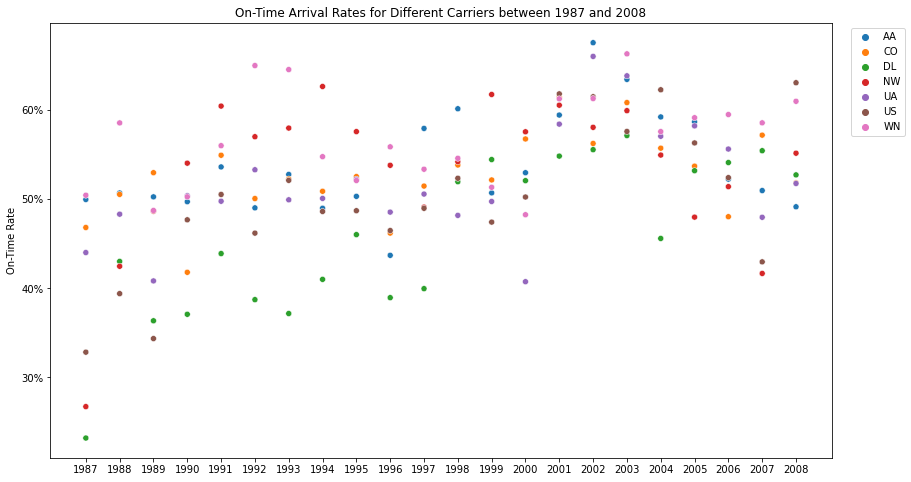

In [39]:
plt.figure(figsize=[14, 8])
sb.scatterplot(data=df, x='Year', y='ArrOnTime', hue='UniqueCarrier', color=base_color)

plt.xticks(np.arange(1987, 2009, 1), np.arange(1987, 2009, 1))
plt.yticks([0.3,0.4,0.5,0.6] , ['30%', '40%', '50%', '60%'])

plt.xlabel('')
plt.ylabel('On-Time Rate')

plt.title('On-Time Arrival Rates for Different Carriers between 1987 and 2008')
plt.legend(bbox_to_anchor=(1.1, 1));

In [40]:
!jupyter nbconvert flights_study_slides.ipynb --to slides --post serve  --no-input --no-prompt

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook flights_study_slides.ipynb to slides
[NbConvertApp] Writing 580768 bytes to flights_study_slides.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "D:\Users\Pototo\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "D:\Users\Pototo\anaconda3\lib\site-packages\jupyter_core\application.py", line 254, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "D:\Users\Pototo\anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "D:\Users\Pototo\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 350, in start
    self.convert_notebooks()
  File "D:\Users\Pototo\anaconda3\lib\site-packages\nbconvert